In [32]:
import os
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy

In [33]:
def ifef(col):
    col = str(col)
    if col in Holiday_1:
        return  'common_holiday'
    if col in Holiday_2:
        return 'key_holiday'
    else:
        return 0

# 1 Data Gathering and Preparation
## 1.1 Data pipeline
### 1.1.1 query data from Big Query

First we went to 
https://cloud.google.com/docs/authentication/getting-started to set up an account and an API key. Then we queried data from Big Query with the JSON file that got downloaded. 

In [4]:
pd.set_option('display.max_columns', 500)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./Predict Taxi Travel Time-d65166414ba3.json"
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../Predict Taxi Travel Time-d65166414ba3.json"
from google.cloud import bigquery
client = bigquery.Client()

### 1.1.2 fetch new data and retrain model

In [4]:
from google.cloud import bigquery
client = bigquery.Client()


query = (
    """SELECT *,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
    EXTRACT (DATE FROM pickup_datetime) as date_of_year
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    LIMIT 10"""
)
df=pd.io.gbq.read_gbq(query,dialect='standard')
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,date_of_year
0,1,2016-03-30 08:18:12+00:00,2016-03-30 08:44:56+00:00,1,8.20,-73.961937,40.767967,1,N,-74.014610,40.714081,1,28.0,0.0,0.5,5.75,0.00,0.3,34.55,1604,2016-03-30
1,1,2016-06-15 11:48:40+00:00,2016-06-15 12:33:04+00:00,1,5.40,-73.995689,40.764603,1,N,-74.010109,40.707829,1,29.0,0.0,0.5,5.96,0.00,0.3,35.76,2664,2016-06-15
2,1,2016-03-14 00:10:26+00:00,2016-03-14 00:23:30+00:00,1,8.00,-73.872993,40.774002,1,Y,-73.972687,40.750912,1,22.5,0.5,0.5,6.00,5.54,0.3,35.34,784,2016-03-14
3,2,2016-10-25 22:23:39+00:00,2016-10-25 22:38:26+00:00,1,8.33,NaN,NaN,1,N,NaN,NaN,1,24.0,0.5,0.5,5.06,0.00,0.3,30.36,887,2016-10-25
4,1,2016-03-09 23:28:26+00:00,2016-03-09 23:52:49+00:00,1,10.20,-74.002869,40.728580,1,N,-73.936104,40.846100,1,30.0,0.5,0.5,7.80,0.00,0.3,39.10,1463,2016-03-09


Here we join with the publicly available weather data. This isn't required, but the goal here is just to show you what's posisble
with big query. Spend some time exploring the public data and coming up with hypotheses!

In [9]:
query = (
    """   
    SELECT * FROM 
    (
    SELECT *,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
     EXTRACT (DAY FROM pickup_datetime) as day_of_year,
     EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
     EXTRACT (YEAR FROM pickup_datetime) as year_of_year
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016` ) a 
    LEFT JOIN
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) weather_data
    on CAST(a.date_of_year AS STRING)=weather_data.date_of_year2 WHERE CAST(year_of_year AS STRING)='2016'
    Order by date_of_year
    LIMIT 100"""
)
taxi_w=pd.io.gbq.read_gbq(query,dialect='standard')
taxi_w.head()


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,date_of_year,day_of_year,month_of_year,year_of_year,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,1,2016-01-01 12:19:32+00:00,2016-01-01 12:21:40+00:00,1,0.40,-73.999992,40.733124,1,N,-73.996094,40.738293,2,3.5,0.0,0.5,0.00,0.0,0.3,4.30,128,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
1,2,2016-01-01 06:43:01+00:00,2016-01-01 06:44:50+00:00,1,0.19,-73.951981,40.777630,1,N,-73.954849,40.778198,1,3.0,0.0,0.5,0.76,0.0,0.3,4.56,109,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
2,1,2016-01-01 14:31:52+00:00,2016-01-01 14:33:09+00:00,1,0.50,-73.952080,40.773232,1,N,-73.949753,40.779720,2,3.5,0.0,0.5,0.00,0.0,0.3,4.30,77,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
3,2,2016-01-01 10:36:43+00:00,2016-01-01 10:38:58+00:00,5,0.46,-73.969505,40.753567,1,N,-73.975426,40.752163,1,4.0,0.0,0.5,0.96,0.0,0.3,5.76,135,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
4,2,2016-01-01 22:48:28+00:00,2016-01-01 22:50:17+00:00,1,0.45,-73.989868,40.741032,1,N,-73.993759,40.736095,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,109,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0


Besides, we also add the performance in stock market into our model.

In [10]:
query = (
    """SELECT *
    FROM `predict-taxi-travel-time.GSPC.daily`
    order by Date
    LIMIT 10"""
    
)
stock_sample=pd.io.gbq.read_gbq(query,dialect='standard')
stock_sample.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2015-12-28,2057.770020,2057.770020,2044.199951,2056.500000,2056.500000,2492510000
1,2015-12-29,2060.540039,2081.560059,2060.540039,2078.360107,2078.360107,2542000000
2,2015-12-30,2077.340088,2077.340088,2061.969971,2063.360107,2063.360107,2367430000
3,2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000
4,2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000


## 1.2 Data integrity checks
### 1.2.1 missing values and outliers

There is no missing value in pickup time and dropoff time.

We remove the records that has missing value in pickup longtitude, pickup latitude, dropoff longtitude, dropff latitude.

For outlier, we will remove the trip with the following features:
<br>&emsp;&emsp; 1. Pickup or dropoff locations is outside New York City. We defined the citi boarder as longtitude between -74.26 and -73.69 and latitude between 40.49 and 40.92.
<br>&emsp;&emsp; 2. Trip distance has negative number or larger than 100 mile.
<br>&emsp;&emsp; 3. Travel time is over 15000 seconds or negative.
<br>&emsp;&emsp; 4. Average speed is over 100 mile per hour


In [17]:
query =  (
"""
CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  111.045 * 180 * x / ACOS(-1)
);
CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
  CASE
    WHEN x <=1 and x>=-1 THEN ACOS(x)
    ELSE NULL
  END
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
    VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
);
SELECT *
FROM
    (SELECT 
        * , (trip_distance*1000)/travel_time as speed # calculate speed for each trip
    FROM (
        SELECT 
            *,TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) as travel_time,
            CAST(EXTRACT(DATE FROM pickup_datetime) AS STRING) as date_of_year,
            EXTRACT(HOUR FROM pickup_datetime) as hour,
            HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS distance_in_km
        FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        WHERE 
            pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and dropoff_longitude IS NOT NULL 
            AND pickup_latitude > 40.49 AND pickup_latitude < 40.92 
            AND dropoff_latitude > 40.49 AND dropoff_latitude < 40.92 
            AND pickup_longitude > -74.26 AND pickup_longitude< -73.69 
            AND dropoff_longitude > -74.26 AND dropoff_longitude < -73.69 
            AND trip_distance > 0 AND trip_distance < 100
    ) A
    WHERE travel_time > 0 and travel_time < 15000  ) B
WHERE 
    speed < 28 and RAND() < 0.0000001
order by pickup_datetime;
"""
)
df=pd.io.gbq.read_gbq(query,dialect='standard')
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,date_of_year,hour,distance_in_km,speed
0,1,2016-03-06 09:18:25+00:00,2016-03-06 09:39:25+00:00,1,3.8,-73.997627,40.765152,1,N,-73.982521,40.728779,1,17.0,0.0,0.5,4.45,0.0,0.3,22.25,1260,2016-03-06,9,4.234268,3.015873
1,1,2016-03-18 23:47:16+00:00,2016-03-18 23:52:48+00:00,1,1.1,-73.976089,40.786324,1,N,-73.979698,40.776295,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,332,2016-03-18,23,1.154251,3.313253


### 1.2.2 information leakage

 We deleted 'fare_amount','tip_amount','tolls_amount','total_amount', since they are directly related to the travel time. And we cannot use them to predict travel time.

### 1.2.3 non-sensical or redundant variables

vendor_id, rate_code, store_and_fwd_flag, payment_type,extra and surcharge are redundant variables and we deleted.

## 1.3 Feature Engineering
### 1.3.1 convert categorical features

We converted month, day, weekday, hour to dummy variables. (i.e: 6 months to 6 dummy variables using one hot encoded) Specific sample code see below.

In [25]:
query = (
"""
    SELECT
                EXTRACT (DATE FROM pickup_datetime) as date_of_year,
                pickup_datetime,
                TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) AS travel_time,
                trip_distance,
                pickup_latitude,
                pickup_longitude,
                dropoff_latitude,
                dropoff_longitude,
                passenger_count
        FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        WHERE 
            pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and dropoff_longitude IS NOT NULL 
            AND pickup_latitude > 40.49 AND pickup_latitude < 40.92 
            AND dropoff_latitude > 40.49 AND dropoff_latitude < 40.92 
            AND pickup_longitude > -74.26 AND pickup_longitude< -73.69 
            AND dropoff_longitude > -74.26 AND dropoff_longitude < -73.69 
            AND trip_distance > 0 AND trip_distance < 100
        limit 10
 """
)
df=pd.io.gbq.read_gbq(query,dialect='standard')

,date_of_year,pickup_datetime,travel_time,trip_distance,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
0,2016-02-17,2016-02-17 12:44:17+00:00,1833,10.50,40.763367,-73.981140,40.773697,-73.870430,1
1,2016-04-28,2016-04-28 07:22:52+00:00,2127,7.39,40.786049,-73.950768,40.867279,-73.905830,1
2,2016-05-17,2016-05-17 08:39:35+00:00,3548,9.40,40.769150,-73.862549,40.754116,-73.986877,2
3,2016-05-26,2016-05-26 15:26:23+00:00,2112,9.80,40.755226,-73.984070,40.768360,-73.861664,1
4,2016-02-24,2016-02-24 14:00:45+00:00,1788,11.10,40.769760,-73.863510,40.765205,-73.975357,1


In [26]:
# Extract Month, Day, Weekday, Hour from pickup_datetime
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)  
df.loc[:,'pickup_day'] =  df['pickup_datetime'].dt.day
df.loc[:,'pickup_month'] =  df['pickup_datetime'].dt.month
df.loc[:,'pickup_hour'] =  df['pickup_datetime'].dt.hour
df.loc[:,'pickup_weekday'] =  df['pickup_datetime'].dt.weekday+1
# Convert catagorical variables to dummy variables using one hot encode
passenger_count = pd.get_dummies(df['passenger_count'], prefix='pc', prefix_sep='_')  
month = pd.get_dummies(df['pickup_month'], prefix='m', prefix_sep='_')   
dom = pd.get_dummies(df['pickup_day'], prefix='dom', prefix_sep='_')  
hour = pd.get_dummies(df['pickup_hour'], prefix='h', prefix_sep='_')  
dow = pd.get_dummies(df['pickup_weekday'], prefix='dow', prefix_sep='_')  
# merge the dummy variables to the origianl table
dat = pd.concat([df,  passenger_count, month,dom,hour,dow], axis=1)
dat.head()

,date_of_year,pickup_datetime,travel_time,trip_distance,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,pickup_day,pickup_month,pickup_hour,pickup_weekday,pc_1,pc_2,pc_5,m_2,m_3,m_4,m_5,m_6,dom_1,dom_17,dom_20,dom_21,dom_24,dom_25,dom_26,dom_28,h_7,h_8,h_12,h_13,h_14,h_15,h_18,h_19,h_20,h_22,dow_1,dow_2,dow_3,dow_4,dow_7
0,2016-02-17,2016-02-17 12:44:17+00:00,1833,10.50,40.763367,-73.981140,40.773697,-73.870430,1,17,2,12,3,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2016-04-28,2016-04-28 07:22:52+00:00,2127,7.39,40.786049,-73.950768,40.867279,-73.905830,1,28,4,7,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2016-05-17,2016-05-17 08:39:35+00:00,3548,9.40,40.769150,-73.862549,40.754116,-73.986877,2,17,5,8,2,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2016-05-26,2016-05-26 15:26:23+00:00,2112,9.80,40.755226,-73.984070,40.768360,-73.861664,1,26,5,15,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,2016-02-24,2016-02-24 14:00:45+00:00,1788,11.10,40.769760,-73.863510,40.765205,-73.975357,1,24,2,14,3,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### 1.3.2 transform variables 

#### 1. linear model: adding squared trip distance to the model.


We calculated the sum of parallel distance in the longitude and latitude direction to estimate the trip distance.

In [15]:
query_parallel_dis = (
"""
    CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
        ACOS(-1) * x / 180
    );
    CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
        111.045 * 180 * x / ACOS(-1)
    );
    CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
        CASE
            WHEN x <=1 and x>=-1 THEN ACOS(x)
            ELSE NULL
          END
    );
    CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        RADIANS_TO_KM(
            VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
            COS(RADIANS(long1) - RADIANS(long2)) +
            SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
    );
    CREATE TEMP FUNCTION PARALLEL_DISTANCE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        HAVERSINE(lat1, long1, lat1, long2) +
        HAVERSINE(lat1, long1, lat2, long1)
    );

    SELECT
        pickup_latitude,
        pickup_longitude,
        dropoff_latitude,
        dropoff_longitude,
        PARALLEL_DISTANCE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS Parallel_Distance
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    WHERE pickup_latitude IS NOT NULL AND 
        pickup_latitude > 40.49 AND pickup_latitude < 40.92 AND 
        dropoff_latitude > 40.49 AND dropoff_latitude < 40.92 AND 
        pickup_longitude > -74.26 AND pickup_longitude< -73.69 AND 
        dropoff_longitude > -74.26 AND dropoff_longitude < -73.69
    LIMIT 50;
"""
)
df = pd.io.gbq.read_gbq(query_parallel_dis,dialect='standard')

In [16]:
df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,Parallel_Distance
0,40.716515,-73.997177,40.777653,-73.954987,10.336839
1,40.790916,-73.970963,40.731342,-73.991661,8.357138
2,40.780960,-73.956718,40.730331,-74.001740,9.410522
3,40.720814,-74.005386,40.685833,-73.929634,10.263153
4,40.772034,-73.958992,40.774330,-73.872536,7.525380


#### 2. Transform of trip duration

In [33]:
 query_trip_duration = (
"""

    SELECT 
            *
    FROM (
            SELECT
                TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) AS travel_time,
                trip_distance
            FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL AND dropoff_longitude IS NOT NULL AND 
                pickup_latitude > 40.21 AND pickup_latitude < 40.92 AND 
                dropoff_latitude > 40.21 AND dropoff_latitude < 40.92 AND 
                pickup_longitude > -74.68 AND pickup_longitude< -72.09 AND 
                dropoff_longitude > -74.68 AND dropoff_longitude < -72.09
                AND trip_distance > 0 AND passenger_count >0 and dropoff_datetime!=pickup_datetime
                AND  RAND() < 23333/131165043 #total records in dataset
    ) A
    WHERE travel_time > 0 AND 
            travel_time < 36000 
    """
)
df = pd.io.gbq.read_gbq(query_trip_duration,dialect='standard')

Text(0,0.5,'number of train records')

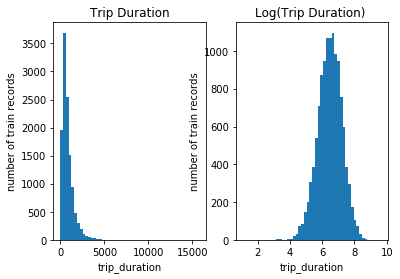

In [42]:
# split the screen into 2 part
fig, [ax1,ax2] = plt.subplots(ncols=2, nrows=1)  
# The distribution of travel time before transformation
ax1.hist(df['travel_time'],bins=50)
ax1.set_title("Trip Duration")
ax1.set_xlabel('trip_duration')  
ax1.set_ylabel('number of train records')  
# The distribution of travel time after log transformation
ax2.hist(np.log(df['travel_time'].values),bins=50)
ax2.set_title("Log(Trip Duration) ")
ax2.set_xlabel('trip_duration')  
ax2.set_ylabel('number of train records')  

### 1.3.3 make new variables from the old ones

In [17]:
from math import radians, cos, sin, asin, sqrt
 
def haversine(lon1, lat1, lon2, lat2): # longitude1，latitude1，longitude2，latitude2 
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # transfered into radian
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378.137 # radius of earth.
    return c * r * 1000

haversine(-74,40,-74.01,40.01)

1402.2448115111113

In [18]:
query_freq=(
    """
    SELECT pk_lon, pk_lat, count(*) as freq
    FROM
    (SELECT *,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
    EXTRACT (DATE FROM pickup_datetime) as date_of_year,
    EXTRACT (DAY FROM pickup_datetime) as day_of_year,
    EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
    EXTRACT (YEAR FROM pickup_datetime) as year_of_year,
    ROUND(pickup_longitude, 3) as pk_lon,
    ROUND(pickup_latitude, 3) as pk_lat
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016` 
    WHERE pickup_longitude is not NULL
    )
    GROUP by pk_lon, pk_lat
    ORDER by freq desc
    LIMIT 50
    """
)
df_taxi_freq = pd.io.gbq.read_gbq(query_freq, dialect='standard')

In [19]:
df_taxi_freq = df_taxi_freq.iloc[1:, ]

In [20]:
import pandas as pd
df_taxi_freq = pd.DataFrame(df_taxi_freq)
df_taxi_freq.sort_values(["pk_lon"],ascending=True)

,pk_lon,pk_lat,freq
44,-74.007,40.744,91806
23,-74.006,40.740,120273
22,-74.004,40.742,121425
41,-73.997,40.737,93451
19,-73.995,40.750,145001
21,-73.995,40.740,121561
45,-73.994,40.746,91566
1,-73.994,40.751,408195
39,-73.993,40.743,94014
17,-73.992,40.749,159191


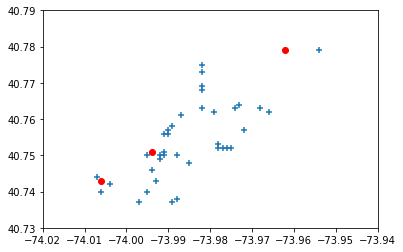

In [21]:
import matplotlib.pyplot as plt
plt.scatter(df_taxi_freq.pk_lon,df_taxi_freq.pk_lat, marker='+')
plt.scatter(-73.994, 40.751, color = "red", marker='o')
plt.scatter(-73.873, 40.774, color = "red", marker='o')
plt.scatter(-73.782, 40.645, color = "red", marker='o')
plt.scatter(-74.006, 40.743, color = "red", marker='o')
plt.scatter(-73.962, 40.779, color = "red", marker='o')
plt.xlim(-74.02, -73.94)
plt.ylim(40.73, 40.79)
plt.show()

Pennsylvania Station (-73.994, 40.751)

LAG (-73.873, 40.774)

JFK (-73.782, 40.645)

Chelsea Market (-74.006, 40.743)

The Metropolitan Museum of Art (-73.962, 40.779)

In [22]:
query_new_distance = (
    """
    CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
        ACOS(-1) * x / 180
    );
    CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
        111.045 * 180 * x / ACOS(-1)
    );
    CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
        CASE
            WHEN x <=1 and x>=-1 THEN ACOS(x)
            ELSE NULL
          END
    );
    CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        RADIANS_TO_KM(
            VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
            COS(RADIANS(long1) - RADIANS(long2)) +
            SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
    );
    CREATE TEMP FUNCTION TO_PEN_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.751, -73.994)
    );
    CREATE TEMP FUNCTION TO_LAG_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.774, -73.873)
    );
    CREATE TEMP FUNCTION TO_JFK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.645, -73.782)
    );
    CREATE TEMP FUNCTION TO_CSMK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.743, -74.006)
    );
    CREATE TEMP FUNCTION TO_MMOA_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.779, -73.962)
    );
    
SELECT
  pickup_latitude,
  pickup_longitude,
  TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) AS travel_time,
  TO_PEN_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_PEN_DISTANCE,
  TO_LAG_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_LAG_DISTANCE,
  TO_JFK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_JFK_DISTANCE,
  TO_CSMK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_CSMK_DISTANCE,
  TO_MMOA_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_MMOA_DISTANCE,
  TO_PEN_DISTANCE(pickup_latitude, pickup_longitude) AS pick_PEN_DISTANCE,
  TO_LAG_DISTANCE(pickup_latitude, pickup_longitude) AS pick_LAG_DISTANCE,
  TO_JFK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_JFK_DISTANCE,
  TO_CSMK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_CSMK_DISTANCE,
  TO_MMOA_DISTANCE(pickup_latitude, pickup_longitude) AS pick_MMOA_DISTANCE
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL AND 
    dropoff_longitude IS NOT NULL AND 
    HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude)>0.1 
LIMIT 100;
"""
)
df_new_distance = pd.io.gbq.read_gbq(query_new_distance, dialect='standard')

In [23]:
df_new_distance.head()

,pickup_latitude,pickup_longitude,travel_time,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE
0,40.716515,-73.997177,1268,4.418841,6.906264,20.712325,5.763504,0.608425,3.838753,12.242890,19.784130,3.033336,7.543415
1,40.790916,-73.970963,2320,2.191740,11.048761,20.089462,1.769574,5.850803,4.837429,8.448441,22.704191,6.082353,1.522787
2,40.780960,-73.956718,1660,2.385728,11.865790,20.787853,1.451739,6.354675,4.571632,7.082102,21.076312,5.911821,0.494574
3,40.720814,-74.005386,1554,9.039546,10.888804,13.236205,9.033986,10.698197,3.486260,12.606369,20.608995,2.464213,7.420886
4,40.772034,-73.958992,1459,10.539460,0.053558,16.258185,11.752797,7.540909,3.758389,7.234765,20.517256,5.101856,0.813879


### 1.3.4 join other interesting data sets

#### 1.3.4.1 weather and holidy

Weather data in BigQuery is as following:

In [24]:
query = (
    """
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     from `bigquery-public-data.noaa_gsod.gsod2016` 
     WHERE stn='725053' AND CAST(year AS STRING)='2016'
     ORDER BY date_of_year2
    """
)
weather_df=pd.io.gbq.read_gbq(query,dialect='standard')
weather_df.head()


,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
1,2016-01-02,2016,01,02,35.8,10.0,6.0,18.1,42.1,32.0,0.00,999.9,0,0,0,0,0
2,2016-01-03,2016,01,03,38.4,10.0,6.4,21.0,45.0,32.0,0.00,999.9,0,0,0,0,0
3,2016-01-04,2016,01,04,30.8,10.0,7.0,22.0,39.0,19.9,0.00,999.9,0,0,0,0,0
4,2016-01-05,2016,01,05,18.4,10.0,6.2,22.0,36.0,10.9,0.00,999.9,0,0,0,0,0


We created holiday data by ourself. It contains important holiday and unimportant holiday.

In [26]:
Holiday_2 = ['2016-01-01', '2016-01-18', '2016-02-14', '2016-03-27', '2016-03-28', '2016-07-04','2016-09-05', 
             '2016-10-31', '2016-11-24', '2016-11-25', '2016-12-24', '2016-12-25', '2016-12-31']
Holiday_1 = ['2016-01-24', '2016-02-02', '2016-02-09', '2016-03-13', '2016-03-17', '2016-03-25','2016-04-01', 
             '2016-04-22', '2016-05-05', '2016-05-08', '2016-05-15', '2016-05-16', '2016-05-21', '2016-05-30', 
             '2016-06-14', '2016-06-19', '2016-07-24', '2016-09-11', '2016-09-16', '2016-09-17', '2016-09-23',
             '2016-10-10', '2016-10-15', '2016-10-17', '2016-11-06', '2016-11-11', '2016-11-28', '2016-12-07']
    
weather_df['holiday'] = weather_df['date_of_year2'].apply(ifef)
df_holiday = pd.get_dummies(weather_df['holiday'])
weather_df_new = weather_df.join(df_holiday)
weather_df_new = weather_df_new.drop(['holiday',0] ,axis=1)
weather_df_new.head()

,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday
0,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1
1,2016-01-02,2016,01,02,35.8,10.0,6.0,18.1,42.1,32.0,0.00,999.9,0,0,0,0,0,0,0
2,2016-01-03,2016,01,03,38.4,10.0,6.4,21.0,45.0,32.0,0.00,999.9,0,0,0,0,0,0,0
3,2016-01-04,2016,01,04,30.8,10.0,7.0,22.0,39.0,19.9,0.00,999.9,0,0,0,0,0,0,0
4,2016-01-05,2016,01,05,18.4,10.0,6.2,22.0,36.0,10.9,0.00,999.9,0,0,0,0,0,0,0


#### 1.3.4.2 stock

We downloaded the S&P 500 data from YAHOO and upload it into BigQuery.

In [27]:
stock = (
    """
        SELECT CAST(Date AS STRING) as Date, Adj_Close
        FROM `predict-taxi-travel-time.GSPC.daily`
        ORDER BY Date
   """
)
stock=pd.io.gbq.read_gbq(stock,dialect='standard')

#### 1.3.4.3 merge

In [28]:

stock_logrtn = {'Date': stock[1:]["Date"].values  ,"logrtn" : numpy.log(stock[1:]["Adj_Close"].values/stock[0:-1]["Adj_Close"].values)*100 }
stock_logrtn = pd.DataFrame(stock_logrtn)
weather_stock = pd.merge(weather_df_new,
             stock_logrtn[["Date","logrtn"]],
             left_on = "date_of_year2",
             right_on = "Date",
             how = "left"
            )
weather_stock['logrtn'].fillna(0, inplace=True)
weather_stock = weather_stock.drop(['Date', 'year'], axis = 1)
# weather_stock.to_csv('../data/weather_stock.csv', index = False)
# `predict-taxi-travel-time.Weather_stock.2016`
weather_stock.head()

,date_of_year2,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn
0,2016-01-01,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1,0.000000
1,2016-01-02,01,02,35.8,10.0,6.0,18.1,42.1,32.0,0.00,999.9,0,0,0,0,0,0,0,0.000000
2,2016-01-03,01,03,38.4,10.0,6.4,21.0,45.0,32.0,0.00,999.9,0,0,0,0,0,0,0,0.000000
3,2016-01-04,01,04,30.8,10.0,7.0,22.0,39.0,19.9,0.00,999.9,0,0,0,0,0,0,0,-1.542204
4,2016-01-05,01,05,18.4,10.0,6.2,22.0,36.0,10.9,0.00,999.9,0,0,0,0,0,0,0,0.201020


In [11]:
query_taxi_tidy = (
"""
    CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
        ACOS(-1) * x / 180
    );
    CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
        111.045 * 180 * x / ACOS(-1)
    );
    CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
        CASE
            WHEN x <=1 and x>=-1 THEN ACOS(x)
            ELSE NULL
          END
    );
    CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        RADIANS_TO_KM(
            VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
            COS(RADIANS(long1) - RADIANS(long2)) +
            SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
    );
    CREATE TEMP FUNCTION PARALLEL_DISTANCE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        HAVERSINE(lat1, long1, lat1, long2) +
        HAVERSINE(lat1, long1, lat2, long1)
    );
     CREATE TEMP FUNCTION TO_PEN_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.751, -73.994)
    );
    CREATE TEMP FUNCTION TO_LAG_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.774, -73.873)
    );
    CREATE TEMP FUNCTION TO_JFK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.645, -73.782)
    );
    CREATE TEMP FUNCTION TO_CSMK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.743, -74.006)
    );
    CREATE TEMP FUNCTION TO_MMOA_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.779, -73.962)
    );

    SELECT 
        taxi.*,other.*
    FROM
    (
        SELECT
        EXTRACT (DATE FROM pickup_datetime) as date_of_year,
        TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) AS travel_time,
        trip_distance
        pickup_latitude,
        pickup_longitude,
        dropoff_latitude,
        dropoff_longitude,
        pickup_datetime,
        passenger_count,
        trip_distance,
        HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS distance_in_km,
        PARALLEL_DISTANCE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS Parallel_Distance,
        TO_PEN_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_PEN_DISTANCE,
        TO_LAG_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_LAG_DISTANCE,
        TO_JFK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_JFK_DISTANCE,
        TO_CSMK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_CSMK_DISTANCE,
        TO_MMOA_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_MMOA_DISTANCE,
        TO_PEN_DISTANCE(pickup_latitude, pickup_longitude) AS pick_PEN_DISTANCE,
        TO_LAG_DISTANCE(pickup_latitude, pickup_longitude) AS pick_LAG_DISTANCE,
        TO_JFK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_JFK_DISTANCE,
        TO_CSMK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_CSMK_DISTANCE,
        TO_MMOA_DISTANCE(pickup_latitude, pickup_longitude) AS pick_MMOA_DISTANCE
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL AND dropoff_longitude IS NOT NULL AND 
        pickup_latitude > 40.21 AND pickup_latitude < 40.92 AND 
                dropoff_latitude > 40.21 AND dropoff_latitude < 40.92 AND 
                pickup_longitude > -74.68 AND pickup_longitude< -72.09 AND 
                dropoff_longitude > -74.68 AND dropoff_longitude < -72.09 
        AND trip_distance > 0 AND passenger_count >0 
        AND  RAND() < 0.00001#233/(SELECT COUNT(*) FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`)
    ) taxi
    LEFT JOIN
    (
     SELECT *
     FROM `predict-taxi-travel-time.Weather_stock.2016`
    ) other
    ON CAST(taxi.date_of_year AS STRING)=CAST(other.date_of_year2 AS STRING)
    WHERE  EXTRACT(YEAR FROM taxi.pickup_datetime) = 2016 AND 
        taxi.distance_in_km>0.1 AND 
        taxi.travel_time > 0 AND 
        taxi.travel_time < 36000 
        AND (taxi.trip_distance*1000)/taxi.travel_time < 56 # remove outlier
    ORDER BY taxi.date_of_year
"""
)
taxi_tidy = pd.io.gbq.read_gbq(query_taxi_tidy, dialect='standard')
taxi_tidy.head()

,date_of_year,travel_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_datetime,passenger_count,trip_distance,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE,date_of_year2,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn
0,2016-01-01,267,0.60,-73.942963,40.828613,-73.942200,2016-01-01 01:40:02+00:00,2,0.60,0.782484,0.843959,9.656394,8.403229,24.442086,10.915889,5.755210,8.936390,7.906795,23.832256,10.210567,4.992858,2016-01-01,1,1,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1,0.0
1,2016-01-01,1105,5.07,-73.992241,40.703228,-74.010490,2016-01-01 20:34:40+00:00,1,5.07,6.145324,7.486650,5.483347,13.985173,20.300651,4.432621,9.351011,0.662253,10.208661,21.620114,1.921586,3.540962,2016-01-01,1,1,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1,0.0
2,2016-01-01,509,3.90,-73.952576,40.779881,-73.984932,2016-01-01 14:53:04+00:00,1,3.90,5.594068,7.609088,3.296475,9.434949,22.717753,4.462324,1.930746,8.812816,8.686389,24.508540,10.044215,5.048696,2016-01-01,1,1,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1,0.0
3,2016-01-02,456,1.73,-73.975159,40.810066,-73.958618,2016-01-02 18:47:34+00:00,5,1.73,2.397211,3.343004,7.202204,8.237147,23.598376,8.446202,3.461444,4.871104,8.831420,23.075760,6.076014,1.861415,2016-01-02,1,2,35.8,10.0,6.0,18.1,42.1,32.0,0.00,999.9,0,0,0,0,0,0,0,0.0
4,2016-01-03,228,1.60,-73.960358,40.780018,-73.944649,2016-01-03 18:03:08+00:00,2,1.60,2.441140,3.373678,5.254618,6.061862,20.303126,6.597360,1.463377,3.061996,7.476215,19.821469,4.356190,1.944664,2016-01-03,1,3,38.4,10.0,6.4,21.0,45.0,32.0,0.00,999.9,0,0,0,0,0,0,0,0.0


# Get data from BigQuery

In [27]:
query_final = (
"""
    CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
        ACOS(-1) * x / 180
    );
    CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
        111.045 * 180 * x / ACOS(-1)
    );
    CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
        CASE
            WHEN x <=1 and x>=-1 THEN ACOS(x)
            ELSE NULL
          END
    );
    CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        RADIANS_TO_KM(
            VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
            COS(RADIANS(long1) - RADIANS(long2)) +
            SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
    );
    CREATE TEMP FUNCTION PARALLEL_DISTANCE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        HAVERSINE(lat1, long1, lat1, long2) +
        HAVERSINE(lat1, long1, lat2, long1)
    );
     CREATE TEMP FUNCTION TO_PEN_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.751, -73.994)
    );
    CREATE TEMP FUNCTION TO_LAG_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.774, -73.873)
    );
    CREATE TEMP FUNCTION TO_JFK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.645, -73.782)
    );
    CREATE TEMP FUNCTION TO_CSMK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.743, -74.006)
    );
    CREATE TEMP FUNCTION TO_MMOA_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.779, -73.962)
    );
   
    SELECT 
        taxi.*,other.*
    FROM
    (
        SELECT 
            *, (trip_distance*1000)/(travel_time+1) AS speed
        FROM (
            SELECT
                EXTRACT (DATE FROM pickup_datetime) as date_of_year,
                pickup_datetime,
                TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) AS travel_time,
                trip_distance,
                pickup_latitude,
                pickup_longitude,
                dropoff_latitude,
                dropoff_longitude,
                passenger_count,
                HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS distance_in_km,
                PARALLEL_DISTANCE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS Parallel_Distance,
                TO_PEN_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_PEN_DISTANCE,
                TO_LAG_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_LAG_DISTANCE,
                TO_JFK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_JFK_DISTANCE,
                TO_CSMK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_CSMK_DISTANCE,
                TO_MMOA_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_MMOA_DISTANCE,
                TO_PEN_DISTANCE(pickup_latitude, pickup_longitude) AS pick_PEN_DISTANCE,
                TO_LAG_DISTANCE(pickup_latitude, pickup_longitude) AS pick_LAG_DISTANCE,
                TO_JFK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_JFK_DISTANCE,
                TO_CSMK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_CSMK_DISTANCE,
                TO_MMOA_DISTANCE(pickup_latitude, pickup_longitude) AS pick_MMOA_DISTANCE
            FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL AND dropoff_longitude IS NOT NULL AND 
                pickup_latitude > 40.6 AND pickup_latitude < 40.91 AND 
                dropoff_latitude > 40.2 AND dropoff_latitude < 41 AND 
                pickup_longitude > -74.07 AND pickup_longitude< -73.69 AND 
                dropoff_longitude > -74.68 AND dropoff_longitude < -73.69
                AND  RAND() < 0.02 
        ) A
        WHERE 
          travel_time >= 0 AND 
          travel_time < 15000 AND trip_distance < 100
    ) taxi
    LEFT JOIN
    (
     SELECT *
     FROM `predict-taxi-travel-time.Weather_stock.2016`
    ) other
    ON CAST(taxi.date_of_year AS STRING)=CAST(other.date_of_year2 AS STRING)
    WHERE taxi.speed < 28 and taxi.distance_in_km >0 and taxi.Parallel_Distance > 0 
    #ORDER BY taxi.date_of_year
"""
)
final = pd.io.gbq.read_gbq(query_final, dialect='standard')

In [29]:
final.describe()

,travel_time,trip_distance,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE,speed,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn
count,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1356701.0,1356701.0,1.356701e+06,1.356701e+06,1.356701e+06
mean,8.386327e+02,2.959175e+00,4.075102e+01,-7.397357e+01,4.075182e+01,-7.397351e+01,1.663276e+00,3.435795e+00,4.439805e+00,3.610074e+00,9.593548e+00,2.034268e+01,4.248165e+00,4.444813e+00,3.296919e+00,9.562404e+00,2.019076e+01,3.936902e+00,4.313658e+00,3.266000e+00,3.516288e+00,1.551398e+01,5.107478e+01,3.197654e+01,3.376703e+01,2.973016e+02,6.203664e+01,4.225862e+01,8.960401e-02,9.447692e+02,4.006410e-02,2.786443e-01,6.911914e-02,0.0,0.0,8.403325e-02,2.551704e-02,1.964191e-02
std,6.592238e+02,3.603520e+00,2.787461e-02,3.776225e-02,3.202252e-02,3.499729e-02,1.313017e+00,3.892681e+00,5.177515e+00,3.356194e+00,2.608564e+00,2.855522e+00,3.420818e+00,3.406335e+00,3.430273e+00,2.508249e+00,3.274667e+00,3.524471e+00,3.416208e+00,1.730093e+00,1.679131e+00,8.702733e+00,1.536992e+01,1.487623e+02,1.663713e+02,4.402307e+02,1.646965e+01,1.470638e+01,2.298868e-01,2.272060e+02,1.961096e-01,4.483322e-01,2.536567e-01,0.0,0.0,2.774378e-01,1.576894e-01,8.423434e-01
min,0.000000e+00,0.000000e+00,4.060006e+01,-7.406906e+01,4.022587e+01,-7.465629e+01,0.000000e+00,9.480729e-05,1.896146e-04,4.377593e-03,2.124191e-03,2.764084e-03,2.153608e-03,7.529872e-03,3.792292e-04,1.896146e-04,1.228843e-03,2.243550e-03,1.038562e-03,0.000000e+00,1.000000e+00,1.000000e+00,6.900000e+00,1.700000e+00,1.200000e+00,1.400000e+01,2.190000e+01,-9.000000e-01,0.000000e+00,1.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,-3.658079e+00
25%,3.980000e+02,1.000000e+00,4.073739e+01,-7.399188e+01,4.073591e+01,-7.399131e+01,1.000000e+00,1.239910e+00,1.580261e+00,1.545734e+00,8.272160e+00,1.998784e+01,2.142665e+00,2.094030e+00,1.455814e+00,8.401160e+00,2.005540e+01,1.978523e+00,2.056098e+00,2.129496e+00,2.000000e+00,8.000000e+00,3.910000e+01,8.800000e+00,3.700000e+00,1.810000e+01,4.890000e+01,3.090000e+01,0.000000e+00,9.999000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,-1.652929e-01
50%,6.630000e+02,1.700000e+00,4.075418e+01,-7.398178e+01,4.075459e+01,-7.397975e+01,1.000000e+00,2.101568e+00,2.699785e+00,2.661809e+00,9.460287e+00,2.066644e+01,3.258597e+00,3.672647e+00,2.368923e+00,9.574938e+00,2.067573e+01,3.009835e+00,3.602028e+00,2.888087e+00,4.000000e+00,1.500000e+01,5.140000e+01,9.800000e+00,4.900000e+00,2.290000e+01,6.210000e+01,4.210000e+01,0.000000e+00,9.999000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.075000e+03,3.180000e+00,4.076841e+01,-7.396737e+01,4.076992e+01,-7.396303e+01,2.000000e+00,3.890057e+00,5.014845e+00,4.505865e+00,1.089007e+01,2.140032e+01,5.412305e+00,5.882879e+00,3.976280e+00,1.091217e+01,2.135638e+01,4.844647e+00,5.678365e+00,3.928571e+00,5.000000e+00,2.300000e+01,6.240000e+01,1.000000e+01,6.400000e+00,9.999000e+02,7.590000e+01,5.200000e+01,5.000000e-02,9.999000e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,3.169611e-01
max,1.486500e+04,7.065000e+01,4.090969e+01,-7.369421e+01,4.099920e+01,-7.369005e+01,9.000000e+00,8.316042e+01,1.130776e+02,7.610156e+01,8.545146e+01,8.3

### 1.3.5 standardize variables 

In [30]:
final.to_csv('train_data_135_filtered.csv', index = False)
#final.to_csv('taxi_data.csv', index = False)
#`predict-taxi-travel-time.nyc_taxi.all_features_for_2016`